In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import sys
import json
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#Add dataset folder to the path
dataset_path = '/kaggle/input/flicker8k-dataset'
sys.path.append(dataset_path)

In [3]:
# Parameters
# Change these parameters as you desire
embed_size = 256
num_layers = 6
max_seq_length = 30
batch_size = 128
num_epochs = 200
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer

In [4]:
class CustomTokenizer:
    def __init__(self, json_file_path, max_seq_length=max_seq_length):
        self.max_length = max_seq_length
        self.pad_token_id = 0
        self.sos_token_id = 1
        self.eos_token_id = 2
        self.unk_token_id = 3        
        self.word2idx = self.build_vocab(json_file_path)
        self.idx2word = {
            self.pad_token_id: "<pad>",
            self.sos_token_id: "<sos>",
            self.eos_token_id: "<eos>",
            self.unk_token_id: "<unk>"
        }
        self.idx2word.update({v: k for k, v in self.word2idx.items()})
    
    def build_vocab(self, json_file_path):
        with open(json_file_path, 'r') as f:
            vocab = json.load(f)
        return vocab

    def encode(self, caption):
        words = caption.split()
        tokens = [self.sos_token_id]
        for word in words:
            token_id = self.word2idx.get(word, self.unk_token_id)
            tokens.append(token_id)        
        tokens.append(self.eos_token_id)        
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            pad_length = self.max_length - len(tokens)
            tokens.extend([self.pad_token_id] * pad_length)
        attention_mask = [False if token != self.pad_token_id else True for token in tokens]
        return tokens, attention_mask

    def decode(self, tokens):
        words = []
        for token in tokens:
            if token in [self.pad_token_id, self.sos_token_id, self.eos_token_id]:
                continue
            word = self.idx2word.get(token, "[UNK]")
            words.append(word)
        caption = " ".join(words)
        return caption
#test the tokenizer
tokenizer = CustomTokenizer(json_file_path="/kaggle/input/json-file/word_to_id.json")
text = "a man riding a horse"
encoded_caption, attention_mask = tokenizer.encode(text)
decoded_caption = tokenizer.decode(encoded_caption)
assert decoded_caption == text

# Dataset

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, image_folder, captions_file, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.data = []
        with open(captions_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            line = line.strip()
            parts = line.split('\t')
            key, caption = parts[0], parts[1]
            image_filename = key.split('#')[0]
            if image_filename.endswith('.jpg'):
                self.data.append({'image': image_filename.lower(), 'caption': caption.lower()})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_filename = item['image']
        caption = item['caption']
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        tokens, attention_mask = self.tokenizer.encode(caption)
        tokens = torch.tensor(tokens, dtype=torch.long)
        attention_mask = torch.tensor(attention_mask, dtype=torch.bool)
        return image, tokens, attention_mask

# Models

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.backbone = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
        for param in self.backbone.parameters():
            param.requires_grad = False
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        self.fc = nn.Linear(num_features, embed_size)

    def forward(self, images):
        features = self.backbone(images)  # features shape: (batch_size, num_features)
        features = self.fc(features)       # features shape: (batch_size, embed_size)
        return features

In [7]:
class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, max_seq_length):
        super(DecoderTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, embed_size))
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=8, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)
    
    def forward(self, features, captions, target_pad_mask):
        if features.dim() == 2:
            features = features.unsqueeze(1)
        embeddings = self.embedding(captions) + self.positional_encoding[:, :captions.shape[1], :]
        target_subsequent_mask = nn.Transformer.generate_square_subsequent_mask(captions.shape[1]).to(captions.device)
        outputs = self.transformer_decoder(
            tgt=embeddings,
            memory=features,
            tgt_mask=target_subsequent_mask,
            tgt_key_padding_mask=target_pad_mask
        )
        outputs = self.fc(outputs)
        return outputs

In [8]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, max_seq_length):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderTransformer(embed_size, vocab_size, num_layers, max_seq_length)

    def forward(self, images, captions, target_pad_mask):
        features = self.encoder(images)
        if features.dim() == 2:
            features = features.unsqueeze(1)
        outputs = self.decoder(features, captions, target_pad_mask)
        return outputs

In [9]:
def generate_caption(image_path: str, temperature=1.0, repetition_penalty=1.2):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # (1, channels, height, width)
    with torch.no_grad():
        features = model.encoder(image_tensor)
    if features.dim() == 2:
        features = features.unsqueeze(1)
    caption_tokens = [tokenizer.sos_token_id]
    for _ in range(max_seq_length - 1):
        caption_input = torch.tensor(caption_tokens, dtype=torch.long).unsqueeze(0).to(device)
        target_pad_mask = (caption_input == tokenizer.pad_token_id)
        with torch.no_grad():
            outputs = model.decoder(features, caption_input, target_pad_mask)
        logits = outputs[0, -1, :]  # shape: (vocab_size,)
        logits = logits / temperature
        for token_id in set(caption_tokens):
            logits[token_id] /= repetition_penalty
        probabilities = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1).item()
        caption_tokens.append(next_token)
        if next_token == tokenizer.eos_token_id:
            break
    caption_text = tokenizer.decode(caption_tokens)
    return caption_text

def generate_caption_from_tensor(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image_tensor)  # shape: (1, embed_size) or (1, 1, embed_size)
        if features.dim() == 2:
            features = features.unsqueeze(1)  # ensure shape: (1, 1, embed_size)
        caption_tokens = [tokenizer.sos_token_id]
        for _ in range(max_seq_length - 1):  # already added one token
            caption_input = torch.tensor(caption_tokens, dtype=torch.long).unsqueeze(0).to(device)  # (1, current_seq_length)
            attention_mask = (caption_input == tokenizer.pad_token_id)
            outputs = model.decoder(features, caption_input, attention_mask)
            # outputs shape: (1, current_seq_length, vocab_size)
            logits = outputs[0, -1, :]  # shape: (vocab_size,)
            next_token = logits.argmax(dim=-1).item()
            caption_tokens.append(next_token)
            if next_token == tokenizer.eos_token_id:
                break
    caption_text = tokenizer.decode(caption_tokens)
    model.train()
    return caption_text

# Train Loop

In [10]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    epoch_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, captions, attention_mask in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            attention_mask = attention_mask.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions, attention_mask)
            outputs_flat = outputs.view(-1, outputs.size(-1))
            targets_flat = captions.view(-1)
            loss = criterion(outputs_flat, targets_flat)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        sample_images, _, _ = next(iter(dataloader))
        rand_idx = np.random.randint(0, sample_images.size(0))
        sample_image = sample_images[rand_idx].unsqueeze(0).to(device)
        caption_text = generate_caption_from_tensor(model, sample_image, device)
    return epoch_losses

# Main

In [11]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_folder = os.path.join(dataset_path, 'Flickr8k_Dataset', 'Flicker8k_Dataset')
captions_file = os.path.join(dataset_path, 'Flickr8k_text', 'Flickr8k.token.txt')
dataset = FlickrDataset(image_folder=image_folder, captions_file=captions_file, transform=transform)
dataset.data = dataset.data[:150]
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
vocab_size = len(tokenizer.word2idx)
model = ImageCaptioningModel(embed_size=embed_size, vocab_size=vocab_size, num_layers=num_layers, max_seq_length=max_seq_length)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch_losses = train_model(model, dataloader, criterion, optimizer, num_epochs, device)
torch.save(model.state_dict(), "image_captioning_model.pth")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 130MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/200], Loss: 9.1867
Epoch [2/200], Loss: 8.1870
Epoch [3/200], Loss: 7.6347
Epoch [4/200], Loss: 7.2013
Epoch [5/200], Loss: 6.8231
Epoch [6/200], Loss: 6.4792
Epoch [7/200], Loss: 6.1443
Epoch [8/200], Loss: 5.8346
Epoch [9/200], Loss: 5.5468
Epoch [10/200], Loss: 5.2966
Epoch [11/200], Loss: 5.0575
Epoch [12/200], Loss: 4.8420
Epoch [13/200], Loss: 4.6421
Epoch [14/200], Loss: 4.4637
Epoch [15/200], Loss: 4.2885
Epoch [16/200], Loss: 4.1306
Epoch [17/200], Loss: 3.9757
Epoch [18/200], Loss: 3.8392
Epoch [19/200], Loss: 3.7046
Epoch [20/200], Loss: 3.5826
Epoch [21/200], Loss: 3.4539
Epoch [22/200], Loss: 3.3461
Epoch [23/200], Loss: 3.2383
Epoch [24/200], Loss: 3.1350
Epoch [25/200], Loss: 3.0359
Epoch [26/200], Loss: 2.9446
Epoch [27/200], Loss: 2.8569
Epoch [28/200], Loss: 2.7674
Epoch [29/200], Loss: 2.6828
Epoch [30/200], Loss: 2.6056
Epoch [31/200], Loss: 2.5315
Epoch [32/200], Loss: 2.4643
Epoch [33/200], Loss: 2.3975
Epoch [34/200], Loss: 2.3280
Epoch [35/200], Loss: 2

# Plot

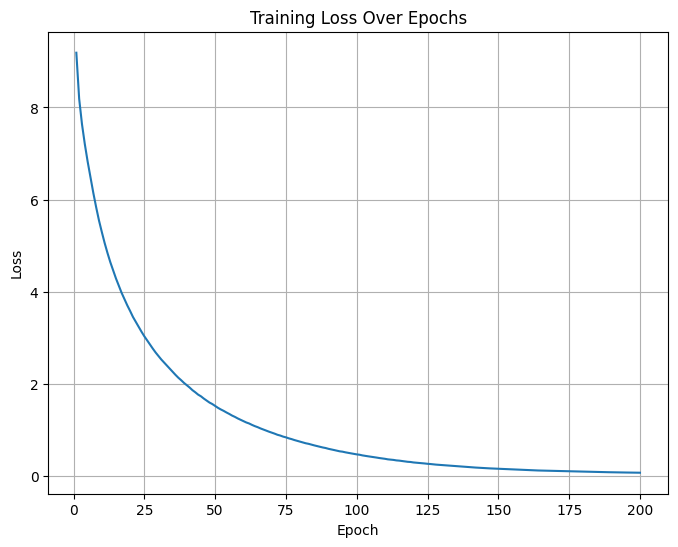

In [113]:
#plot the loss over time
epochs = range(1, len(epoch_losses) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation

Generated Caption: anthem drinking steep halfway climbing climbing shirtless cliff suntan next next next slurpees looking bundle holding spots tychy woamn pizza aerodynamically snout coats eyes dish pink


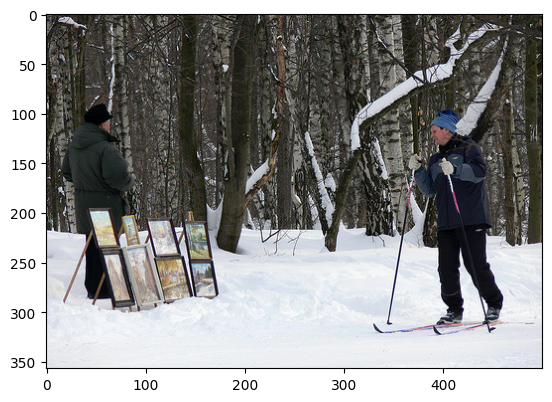

In [13]:
image_path = os.path.join(image_folder, dataset.data[55]['image'])
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
caption = generate_caption(image_path)
print('Generated Caption:', caption)

Generated Caption: suite fighting strokes cart sequins item blue


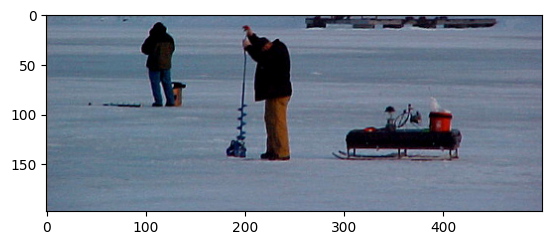

In [110]:
image_path = os.path.join(image_folder, dataset.data[95]['image'])
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
caption = generate_caption(image_path)
print('Generated Caption:', caption)

Generated Caption: fiddles shakes paintball balloons blouse


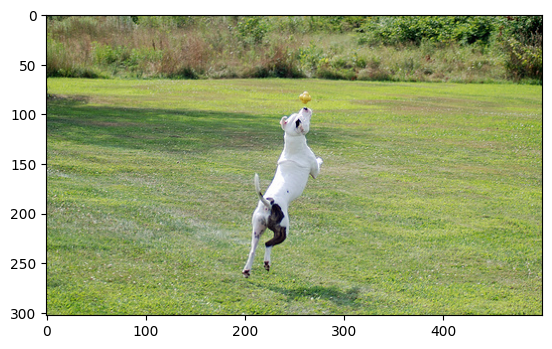

In [78]:
image_path = os.path.join(image_folder, dataset.data[75]['image'])
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
caption = generate_caption(image_path)
print('Generated Caption:', caption)

Generated Caption: picket skis ractrack shovels backgroud a a a a a a a a a a collies this snub ride coiled suits


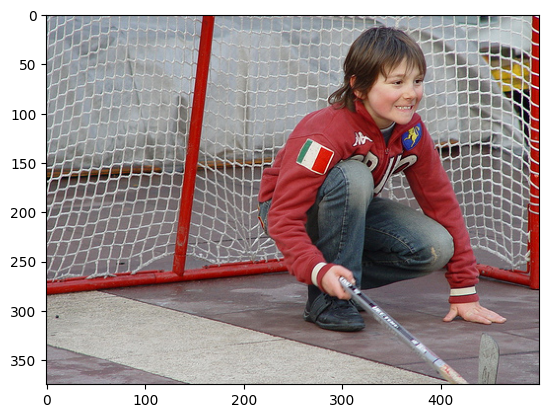

In [82]:
image_path = os.path.join(image_folder, dataset.data[125]['image'])
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
caption = generate_caption(image_path)
print('Generated Caption:', caption)

Generated Caption: earth homes


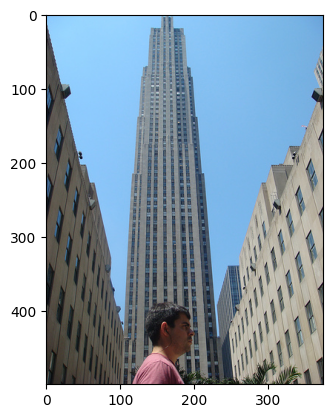

In [59]:
image_path = os.path.join(image_folder, dataset.data[145]['image'])
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
caption = generate_caption(image_path)
print('Generated Caption:', caption)

Generated Caption: carrying kids ends formation rocks squabble stocking short interviewing pedestrians saxaphones cooking


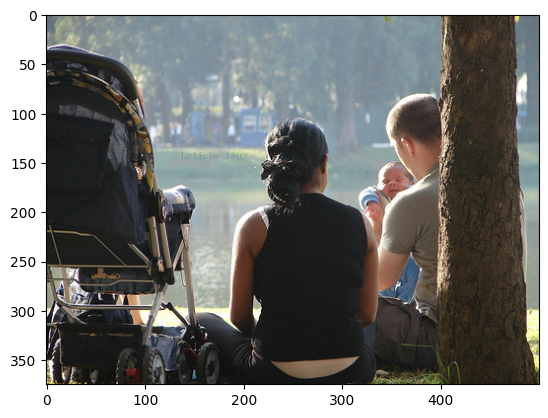

In [64]:
image_path = os.path.join(image_folder, dataset.data[85]['image'])
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
caption = generate_caption(image_path)
print('Generated Caption:', caption)

---